Pairs trading, we need to test the cointegration and stationary of data

Import packages

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'whitegrid')

Stationary v.s. unstationary

/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_94632/3188099302.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  A = pd.Series(index = range(T))
/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_94632/3188099302.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  B = pd.Series(index = range(T))


Text(0.5, 1.0, 'Unstationary')

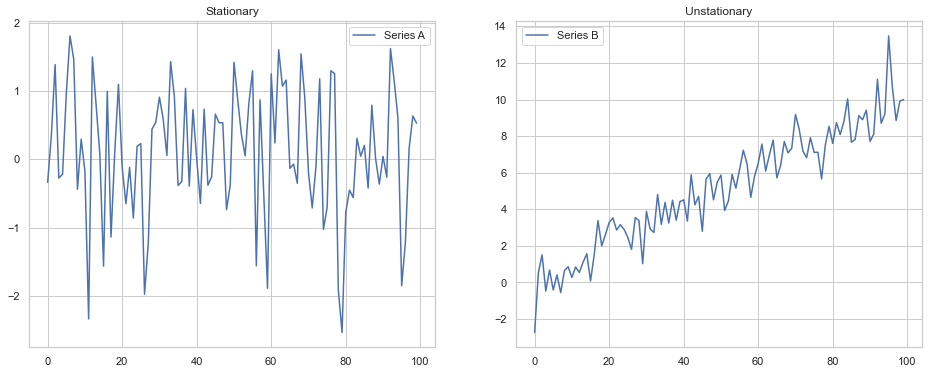

In [2]:
def generate_data(parameters):
    mu = parameters[0] ## the first item in parameters
    sigma = parameters[1] ## the second item in parameters
    return np.random.normal(mu, sigma)

parameters = (0, 1)
T = 100
A = pd.Series(index = range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_data(parameters) ## it will do T times

B = pd.Series(index = range(T))
B.name = 'B'

for t in range(T):
    parameters = (t*0.1, 1) ## the first item of parameter will increase by t, largest = 100 * 0.1 = 10
    B[t] = generate_data(parameters) ## it will do T times

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6)) ## plot two plots in one time
ax1.plot(A)
ax1.legend(['Series A'])
ax1.set_title('Stationary')
ax2.plot(B)
ax2.legend(['Series B'])
ax2.set_title('Unstationary')


Cointegration

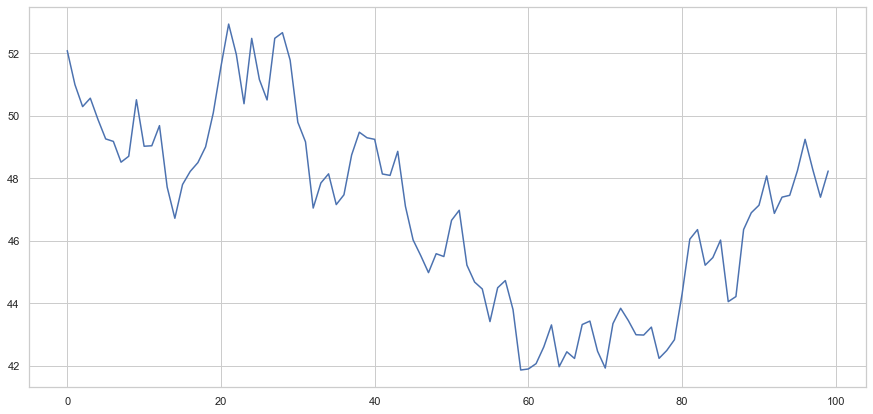

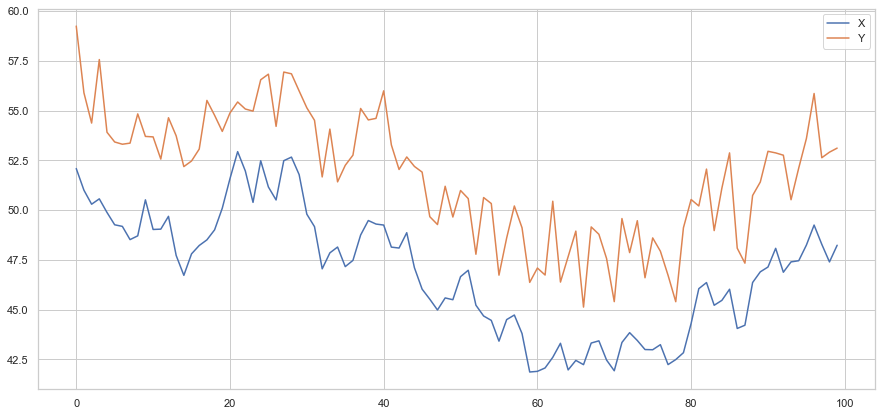

In [17]:
## Generate daily returns
Return = np.random.normal(0, 1, 100) ## define return as random normal sequence

## sum up and rise the daily return
X = pd.Series(np.cumsum(Return), name = 'X') + 50
X.plot(figsize = (15, 7))

noise = np.random.normal(0, 1, 100) ## define noise as random normal sequence
Y = X + noise + 5
Y.name = 'Y'

pd.concat([X, Y], axis=1).plot(figsize=(15, 7)) ## pd.concat is for merging datas

plt.show()


Plot the price spread (price difference between A and B)

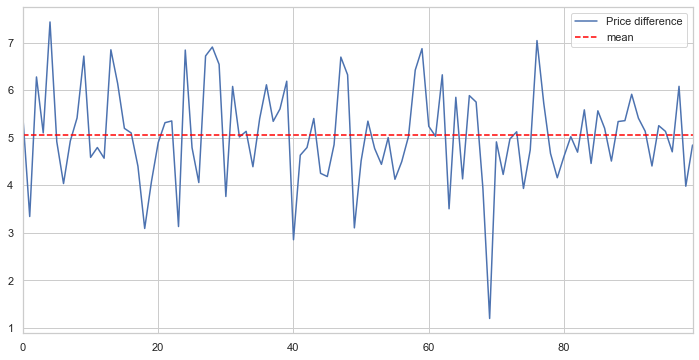

In [4]:
plt.figure(figsize = (12, 6))
(Y - X).plot()
plt.axhline((np.mean(Y - X)), color = 'red', linestyle = '--')
plt.xlabel = 'time'
plt.ylabel = 'price difference'
plt.xlim(0, 99)
plt.legend(['Price difference', 'mean'])

Determine cointegration

In [5]:
score, pvalue, _=coint(X, Y)
print(pvalue) ## small enough, cointegration

1.5914041763156086e-10


Import finance package

In [8]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

Start getting data and working on them

In [9]:
def find_cointegrated_pairs(data):
    n = data.shape[1] ## number of columns of data
    score_matrix = np.zeros(n, n)
    pvalue_matrix = np.ones(n, n)
    keys = data.keys()
    pairs = []

    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [16]:
import tqdm
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2022, 7, 1)
for i in tqdm.tqdm(range(100)):
    tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

100%|██████████| 100/100 [00:00<00:00, 1559220.82it/s]


[*********************100%***********************]  11 of 11 completed


,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2022-06-24,141.660004,387.720001,87.080002,45.669998,35.230000,142.059998,29.150000,267.700012,70.699997,125.099998,390.079987
2022-06-27,141.660004,381.070007,86.160004,44.380001,35.360001,142.800003,29.170000,264.890015,70.410004,127.180000,388.589996
2022-06-28,137.440002,365.630005,80.779999,42.650002,34.439999,141.860001,28.670000,256.480011,68.580002,131.600006,380.649994
2022-06-29,139.229996,368.500000,77.989998,42.669998,33.610001,140.710007,28.790001,260.260010,69.209999,130.229996,380.339996
2022-06-30,136.720001,366.059998,76.470001,41.669998,32.779999,141.190002,28.500000,256.829987,69.870003,127.739998,377.250000
